# The Chess Game Dataset!

The dataset itself comes from [Lichess.org](lichess.org) compiled [here](https://www.kaggle.com/datasets/datasnaek/chess/data).

Thank you [Havisha Khurana](https://github.com/havishak) for putting these data together for us!

This entry is for #tidytuesday week 40 in 2024!  Let's go!

## Setup

In [6]:
# installation
using Pkg
Pkg.add(["DataFrames", "CSV", "HTTP", "StatsPlots", 
"StatsBase", "Plots", "SummaryTables", "DataFramesMeta", 
"Chain", "CategoricalArrays", "Measures", "PlotThemes"
])

# load
using DataFrames, CSV, HTTP, StatsPlots, StatsBase, Plots, SummaryTables, DataFramesMeta, Chain, CategoricalArrays, Measures, PlotThemes

   Resolving package versions...
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Manifest.toml`


ArgumentError: ArgumentError: Package SummaryTables not found in current path.
- Run `import Pkg; Pkg.add("SummaryTables")` to install the SummaryTables package.

In [3]:
# get url
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-10-01/chess.csv"

# use HTTP package
response = HTTP.get(url)

# import data via CSV / HTTP
chess = CSV.read(IOBuffer(response.body), DataFrame)

# inspect
describe(chess)

16×7 DataFrame
 Row │ variable        mean        min                                median   ⋯
     │ Symbol          Union…      Any                                Union…   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ game_id                     005lW0Xz                                    ⋯
   2 │ rated           0.805414    false                              1.0
   3 │ start_time      1.48362e12  1376771633173                      1.49601e
   4 │ end_time        1.48362e12  1376771863841                      1.49601e
   5 │ turns           60.466      1                                  55.0     ⋯
   6 │ victory_status              draw                                       
   7 │ winner                      black                                      
   8 │ time_increment              0+12                                       
   9 │ white_id                    --jim--                                     ⋯
  10 │ white_rating    1596.63     784                                1567.0
  11 │ black_id                    -0olo0-                                    
  12 │ black_rating    1588.83     789                                1562.0
  13 │ moves                       Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 e…           ⋯
  14 │ opening_eco                 A00                                        
  15 │ opening_name                Alekhine Defense                           
  16 │ opening_ply     4.81698     1                                  4.0
                                                               4 columns omitted

## Goals of the analysis for #TidyTuesday Week 40!

* What the common opening moves? By ranks?
* How many turns does a game last based on player ranking?

### Let's break down how we can approach each question using Julia:

1. Common Opening Moves by Ranks

We will focus on the `opening_name` column to identify and rank the most common openings.

2. Game Duration Based on Player Ranking

We'll compare the number of `turns` based on player ranking `white_rating` and `black_rating`.

## A few more manipulations on the data for convenience

In [50]:
# make it easy to identify winners and their rating
chess_rank = @chain begin
    chess
    @transform(:winner_rating = ifelse.(:winner .== "white", :white_rating,
                                    ifelse.(:winner .== "black", :black_rating, 0)),
                :winner_id = ifelse.(:winner .== "white", :white_id,
                ifelse.(:winner .== "black", :black_id, "none"))
                                    )
end;

# get a summary for plotting / further analysis of # wins and avg rating per player
chess_rank_summary = @chain begin
    chess_rank
    groupby(:winner_id)
    combine([:winner_id => length => :N_wins,
            :winner_rating => mean => :Avg_rating
    ])
    sort(:N_wins, rev = true)
    filter(:winner_id => x -> x != "none", _)
end;

## Analyzing Common Opening Moves

We will group by opening_name to get the frequency of each opening.

This will give us the most common openings sorted by frequency.

In [23]:
common_openings = combine(groupby(chess, :opening_name), nrow => :Frequency)
sorted_openings = sort(common_openings, :Frequency, rev=true)

# Display top 10 common openings
top_sorted_openings = first(sorted_openings, 10)

10×2 DataFrame
 Row │ opening_name                       Frequency 
     │ String                             Int64     
─────┼──────────────────────────────────────────────
   1 │ Van't Kruijs Opening                     368
   2 │ Sicilian Defense                         358
   3 │ Sicilian Defense: Bowdler Attack         296
   4 │ French Defense: Knight Variation         271
   5 │ Scotch Game                              271
   6 │ Scandinavian Defense: Mieses-Kot…        259
   7 │ Queen's Pawn Game: Mason Attack          232
   8 │ Queen's Pawn Game: Chigorin Vari…        229
   9 │ Scandinavian Defense                     223
  10 │ Horwitz Defense                          209

## Filter the dataset and use `SummaryTables` to show `opening_name` grouped by `victory_status`

In [34]:
# get a filtered chess dataset using the top opening_names
chess_filtered = filter(:opening_name => x -> x in unique(top_sorted_openings.opening_name), chess)

# summarize using table_one
table_one(
    chess_filtered,
    [:opening_name => "Opening Name", ],
    groupby = :victory_status => "Victory Status",
    show_n = true
)

Table(Cell[Cell(nothing, CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(nothing, CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) … Cell("Victory Status", CellStyle(0.0, true, false, false, true, :center, :top, true, 0x00)) Cell("Victory Status", CellStyle(0.0, true, false, false, true, :center, :top, true, 0x00)); Cell(nothing, CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(Multiline(("Total", "(n=2716)")), CellStyle(0.0, true, false, false, false, :center, :top, false, 0x00)) … Cell(Multiline((String15("outoftime"), "(n=220)")), CellStyle(0.0, false, false, false, false, :center, :top, true, 0x00)) Cell(Multiline((String15("resign"), "(n=1474)")), CellStyle(0.0, false, false, false, false, :center, :top, true, 0x00)); … ; Cell("Sicilian Defense: Bowdler Attack", CellStyle(12.0, false, false, false, false, :left, :top, false, 0x00)) Cell(Concat((296, " (", 10.89837997054492, "%)")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) … Cell(Concat((24, " (", 10.909090909090908, "%)")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(Concat((160, " (", 10.854816824966079, "%)")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)); Cell("Van't Kruijs Opening", CellStyle(12.0, false, false, false, false, :left, :top, false, 0x00)) Cell(Concat((368, " (", 13.549337260677467, "%)")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) … Cell(Concat((27, " (", 12.272727272727273, "%)")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(Concat((171, " (", 11.601085481682496, "%)")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00))], 2, nothing, Any[], Pair{Int64, Float64}[], Pair{Int64, Float64}[], Any[], 3, :auto, false, true)

## Let's check the distribution of `winner_rating`

We want to get a similar table to the above but grouped by ratings.  There are currently 1,486 unique winner ratings in the data, and so we will need to create a categorical variable from the ratings.

In [56]:
length(unique(chess_rank.winner_rating))

1486

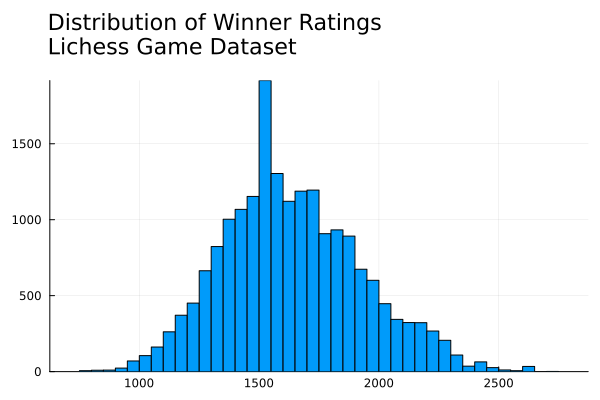

In [55]:
# most common opening moves by ranks
chess_rank_filter = filter(:winner_rating => x -> x != 0, chess_rank) 

@df chess_rank_filter histogram(:winner_rating, legend = false, 
title = "Distribution of Winner Ratings\nLichess Game Dataset\n\n",
titlefontsize = 15, titlealign = :left
)

## A categorical rating variable

In [62]:
# Define ranking categories
chess_rank.ranking_band = cut(chess.white_rating, [600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800])

@chain begin
    chess_rank
    groupby(:ranking_band)
    combine(:ranking_band => length => :Count)
end

11×2 DataFrame
 Row │ ranking_band  Count 
     │ Categorical…  Int64 
─────┼─────────────────────
   1 │ [600, 800)        7
   2 │ [800, 1000)     240
   3 │ [1000, 1200)   1347
   4 │ [1200, 1400)   3453
   5 │ [1400, 1600)   5789
   6 │ [1600, 1800)   4342
   7 │ [1800, 2000)   3073
   8 │ [2000, 2200)   1222
   9 │ [2200, 2400)    464
  10 │ [2400, 2600)     91
  11 │ [2600, 2800)     30

## Analyzing Game Duration by Player Ranking

We categorized players into ranking bands already, and now we can compare game durations based on those rankings.

This will provide a bar plot showing the average number of turns for different rating bands.

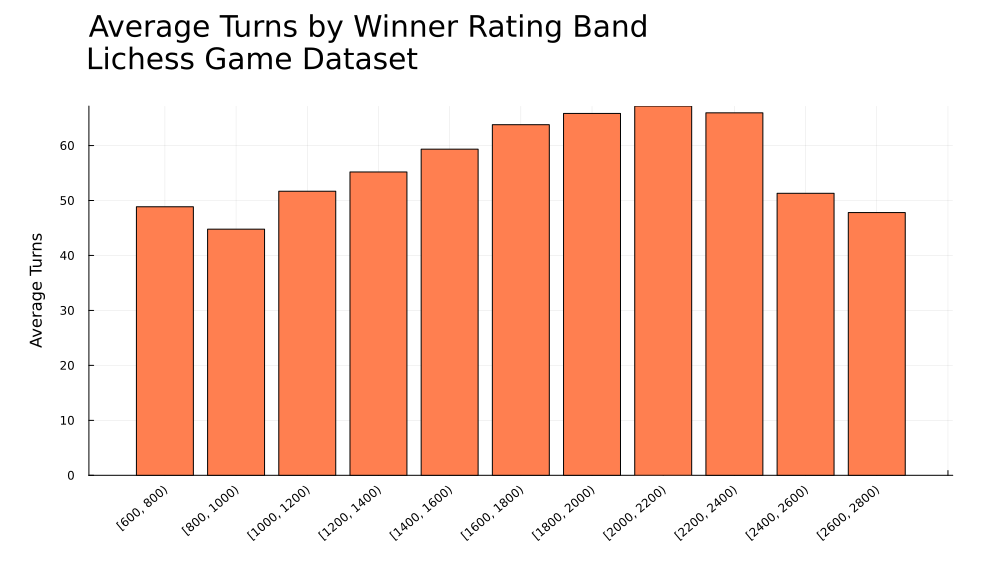

In [73]:
# Group by ranking band and calculate average game length
turns_by_ranking = combine(groupby(chess_rank, :ranking_band), :turns => mean => :avg_turns)

# Plot the result
@df turns_by_ranking bar(:ranking_band, :avg_turns, 
legend = false, xlabel="", ylabel = "Average Turns", 
xrotation = 40, size = (1000, 565), margins = 10mm,
title = "Average Turns by Winner Rating Band\nLichess Game Dataset\n",
titlefontsize = 20, titlealign = :left, color = :coral
)

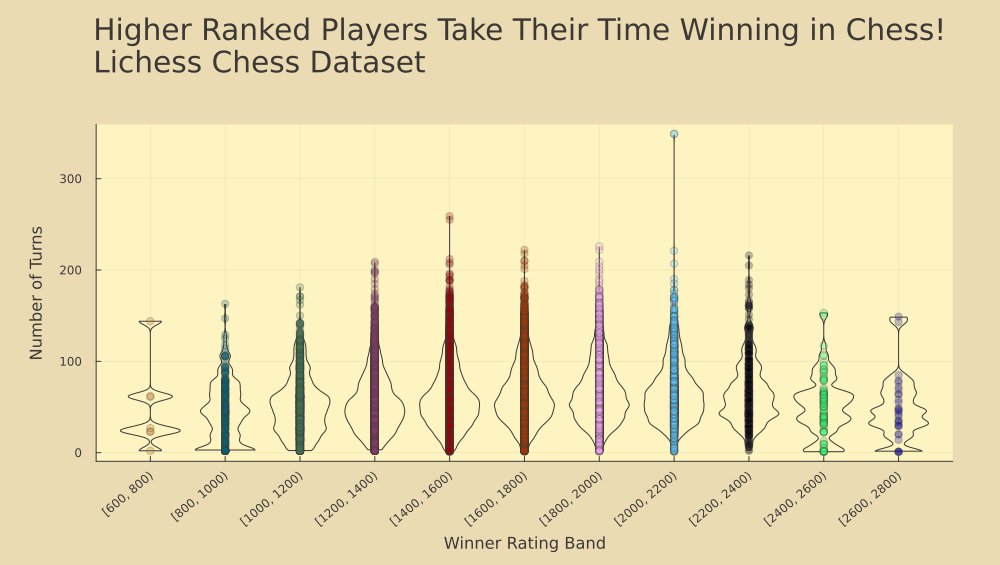

In [106]:
# Create a violin plot of the distribution of turns by ranking band
theme(:gruvbox_light)

@df chess_rank violin(:ranking_band, :turns, 
    xlabel = "Winner Rating Band", 
    ylabel = "Number of Turns", 
    legend = false, 
    title = "Higher Ranked Players Take Their Time Winning in Chess!\nLichess Chess Dataset\n\n",
    size = (1000, 565), 
    xrotation = 40, 
    margins = 10mm, 
    fillalpha = 0, 
    titlefontsize = 20,
    titlealign = :left)
# Overlay the scatter plot with mean values
@df chess_rank scatter!(:ranking_band, :turns, 
group = :ranking_band,
markeralpha = 0.25,
legend = false)

## Interesting, higher ranked players seem to take their time

Let's create a table and see what that looks like alongside our top opening moves.

In [107]:
# create a table that summarizes avg turns per the top 10 opening moves and winning rating band

# get a filtered chess dataset using the top opening_names
chess_rank_filtered = filter(:opening_name => x -> x in unique(top_sorted_openings.opening_name), chess_rank)

# summarize using table_one
table_one(
    chess_rank_filtered,
    [:opening_name => "Opening Name", :turns => "Turns"],
    groupby = :ranking_band => "Winner Ranking Band",
    show_n = true
)

Table(Cell[Cell(nothing, CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(nothing, CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) … Cell("Winner Ranking Band", CellStyle(0.0, true, false, false, true, :center, :top, true, 0x00)) Cell("Winner Ranking Band", CellStyle(0.0, true, false, false, true, :center, :top, true, 0x00)); Cell(nothing, CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(Multiline(("Total", "(n=2716)")), CellStyle(0.0, true, false, false, false, :center, :top, false, 0x00)) … Cell(Multiline((CategoricalValue{String, UInt32} "[2400, 2600)" (10/11), "(n=7)")), CellStyle(0.0, false, false, false, false, :center, :top, true, 0x00)) Cell(Multiline((CategoricalValue{String, UInt32} "[2600, 2800)" (11/11), "(n=1)")), CellStyle(0.0, false, false, false, false, :center, :top, true, 0x00)); … ; Cell("Mean (SD)", CellStyle(12.0, false, false, false, false, :left, :top, false, 0x00)) Cell(Concat((59.2459499263623, " (", 33.7801019456464, ")")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) … Cell(Concat((35.0, " (", 18.717193521821944, ")")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(Concat((33.0, " (", NaN, ")")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)); Cell("Median [Min, Max]", CellStyle(12.0, false, false, false, false, :left, :top, false, 0x00)) Cell(Concat((55.0, " [", 2, ", ", 226, "]")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) … Cell(Concat((33.0, " [", 2, ", ", 57, "]")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00)) Cell(Concat((33.0, " [", 33, ", ", 33, "]")), CellStyle(0.0, false, false, false, false, :center, :top, false, 0x00))], 2, nothing, Any[], Pair{Int64, Float64}[], Pair{Int64, Float64}[], Any[], 3, :auto, false, true)